In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#This function identifies the middle/center contour in an image using the identified contours and a specified point
def middle_contour(contours,point):
    min_dist = float('inf')
    closest_contour = None

    for contour in contours:
        
        dist = cv2.pointPolygonTest(contour,point,True)

        if abs(dist) < min_dist:
            min_dist = abs(dist)
            closest_contour = contour

    return closest_contour

In [16]:
#image preprocessing 
img = cv2.imread('testImage.png') 

#find image width and height
w,h = img.shape[:2]
B,G,R = cv2.split(img)

#convert image to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

th,thresh1_img = cv2.threshold(B,170,255,cv2.THRESH_BINARY)
th,thresh2_img = cv2.threshold(G,170,255,cv2.THRESH_BINARY)
th,thresh3_img = cv2.threshold(R,170,255,cv2.THRESH_BINARY)

anded = cv2.bitwise_and(thresh1_img, thresh2_img, thresh3_img)

kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(anded,kernel,iterations=8) 
dilation = cv2.dilate(erosion,kernel,iterations=15)

#blur image, larger kernel provides closer fit than smaller kernel, but too big a kernel shrinks the paper
blur = cv2.GaussianBlur(dilation,(55,55),0)

#threshold image for white
thresh = cv2.threshold(blur,25,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

#morphological transformation
kernel = np.ones((7,7),np.uint8)
morph = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE, kernel=kernel)
morph = cv2.morphologyEx(morph,cv2.MORPH_OPEN, kernel=kernel)

#find contours, outlines of blurred ROIs 
contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


/var/folders/k7/c0rmybbn2h94nc8bb996p8j00000gn/T/ipykernel_24332/3084591898.py:26: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


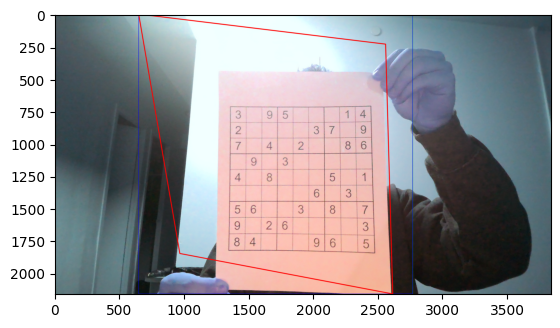

In [17]:
#Method 1: thresholding 

contours = contours[0] if len(contours) == 2 else contours[1]
area_thresh = 0

for c in contours:
    area = cv2.contourArea(c) #find area of the contour
    if area > area_thresh:
        area_thresh = area
        contourMax = c #identify largest contour area -> this should be your paper

paper = np.zeros_like(img)

#draw contour lines on the image using coordinates found in largest contour area
cv2.drawContours(paper,[contourMax], 0, (255,255,255),-1) 

peri = cv2.arcLength(contourMax,True) #parameter for approximation accuracy
#approximate the paper outline with fewer indices, i.e. simplify a more complex shape to rectangle indices
corner = cv2.approxPolyDP(contourMax,0.04*peri, True)

x,y,w,h = cv2.boundingRect(contourMax) #find rectangle that bounds the contour
cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

rect2 = cv2.minAreaRect(contourMax) #find smallest possible rectangle to bind contour
box = cv2.boxPoints(rect2)
box = np.int0(box)
img = cv2.drawContours(img,[box],0,(0,0,255),2)

polygon = img.copy()

#overlay the new shape/polygon
cv2.polylines(polygon,[corner],True,(255,0,0),5,cv2.LINE_AA)

plt.imshow(polygon)

In [18]:
#image preprocessing
img = cv2.imread('testImage.png') 

#find image width and height
w,h = img.shape[:2]
B,G,R = cv2.split(img)

#convert image to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

th,thresh1_img = cv2.threshold(B,170,255,cv2.THRESH_BINARY)
th,thresh2_img = cv2.threshold(G,170,255,cv2.THRESH_BINARY)
th,thresh3_img = cv2.threshold(R,170,255,cv2.THRESH_BINARY)

anded = cv2.bitwise_and(thresh1_img, thresh2_img, thresh3_img)

kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(anded,kernel,iterations=8)
dilation = cv2.dilate(erosion,kernel,iterations=15)

#blur image, larger kernel provides closer fit than smaller kernel, but too big a kernel shrinks the paper
blur = cv2.GaussianBlur(dilation,(55,55),0)

#threshold image for white
thresh = cv2.threshold(blur,25,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

#morphological transformation
kernel = np.ones((7,7),np.uint8)
morph = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE, kernel=kernel)
morph = cv2.morphologyEx(morph,cv2.MORPH_OPEN, kernel=kernel)

#find contours, outlines of blurred ROIs 
contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

/var/folders/k7/c0rmybbn2h94nc8bb996p8j00000gn/T/ipykernel_24332/4050666889.py:23: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


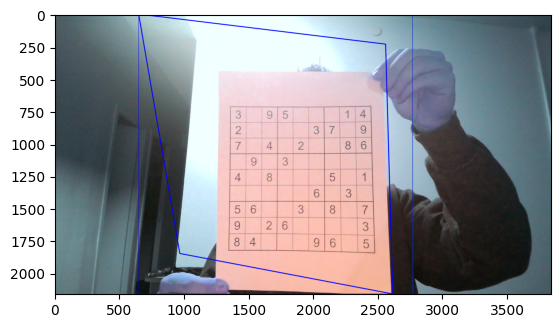

In [19]:
#Method 2: identify center contour of the image 

contours = contours[0] if len(contours) == 2 else contours[1]
area_thresh = 0

point = (np.round(w/2),np.round(h/2)) #identify center point of the image using width and height
middle = middle_contour(contours,point) #use middle_contour function

paper = np.zeros_like(img)

#find contours, outlines of blurred ROIs 
cv2.drawContours(paper,[middle], 0, (255,255,255),-1)

peri = cv2.arcLength(middle,True) #parameter for approximation accuracy
#approximate the paper outline with fewer indices, i.e. simplify a more complex shape to rectangle indices
corner = cv2.approxPolyDP(middle,0.04*peri, True) 

x,y,w,h = cv2.boundingRect(middle) #form rectangle that bounds contour
cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

rect2 = cv2.minAreaRect(contourMax) #make sure rectangle is smallest it can be
box = cv2.boxPoints(rect2)
box = np.int0(box)
img = cv2.drawContours(img,[box],0,(0,0,255),2)

polygon = img.copy()

#overlay the new shape/polygon
cv2.polylines(polygon,[corner],True,(0,0,255),5,cv2.LINE_AA)

plt.imshow(polygon)

In [29]:
#image preprocessing
img = cv2.imread('testImage.png') 

#find image width and height
w,h = img.shape[:2]
B,G,R = cv2.split(img)

#convert image to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

th,thresh1_img = cv2.threshold(B,170,255,cv2.THRESH_BINARY)
th,thresh2_img = cv2.threshold(G,170,255,cv2.THRESH_BINARY)
th,thresh3_img = cv2.threshold(R,170,255,cv2.THRESH_BINARY)

anded = cv2.bitwise_and(thresh1_img, thresh2_img, thresh3_img)

kernel = np.ones((5,5),np.uint8)
#erosion = cv2.erode(anded,kernel,iterations=8)
dilation = cv2.dilate(anded,kernel,iterations=15)

#blur image, larger kernel provides closer fit than smaller kernel, but too big a kernel shrinks the paper
blur = cv2.GaussianBlur(dilation,(55,55),0)

#threshold image for white
thresh = cv2.threshold(blur,25,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]


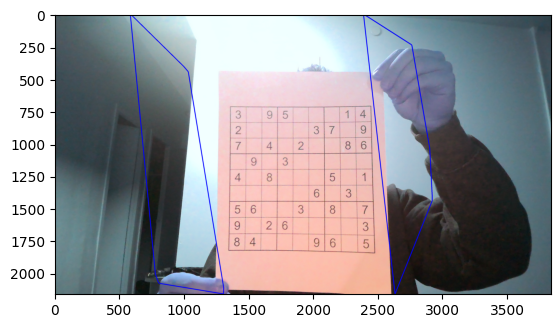

In [30]:
#Method 3: Identify corners and outline their formed shapes

imgCopy = img.copy()

canny = cv2.Canny(thresh,threshold1=120,threshold2=255,edges=1) #find edges

contours, hierarchy = cv2.findContours(canny,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cornerList = []

for i,c in enumerate(contours):

    contoursPoly = cv2.approxPolyDP(c,3,True)

    boundRect = cv2.boundingRect(contoursPoly) #find rectangle that bounds contour shapes

    #rectangle corner points
    rectX = boundRect[0] 
    rectY = boundRect[1]
    rectWidth = boundRect[2]
    rectHeight = boundRect[3]

    rectArea = rectWidth * rectHeight #calculate rectangle area

    minArea = 100000

    #find biggest area rectangle
    if rectArea > minArea:

        hull = cv2.convexHull(c)

        color = (0,0,255)
        cv2.polylines(imgCopy, [hull],True,color,5)

plt.imshow(imgCopy)


In [31]:
#segments the image to find dominant color, i.e. white for the paper
def segment_dominant_color(img,k=3):
    #reshape image into 2D array
    pixels = img.reshape((-1,3))
    pixels = np.float32(pixels)

    #define criteria for k-means clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,10,1.0)

    #apply k-means clustering
    _,labels,centers = cv2.kmeans(pixels,k,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

    #convert labels back to original image
    labels = labels.reshape(img.shape[:2])

    #create mask for dominant color
    dominant_color_mask = np.where(labels == 0,255,0).astype(np.uint8)

    return dominant_color_mask

In [32]:
#image preprocessing
img = cv2.imread('testImage.png') 

#find image width and height
w,h = img.shape[:2]
B,G,R = cv2.split(img)

#convert image to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

th,thresh1_img = cv2.threshold(B,170,255,cv2.THRESH_BINARY)
th,thresh2_img = cv2.threshold(G,170,255,cv2.THRESH_BINARY)
th,thresh3_img = cv2.threshold(R,170,255,cv2.THRESH_BINARY)

anded = cv2.bitwise_and(thresh1_img, thresh2_img, thresh3_img)

kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(anded,kernel,iterations=8)
dilation = cv2.dilate(erosion,kernel,iterations=15)

#blur image, larger kernel provides closer fit than smaller kernel, but too big a kernel shrinks the paper
blur = cv2.GaussianBlur(dilation,(55,55),0)

#threshold image for white
thresh = cv2.threshold(blur,25,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

#morphological transformation
kernel = np.ones((7,7),np.uint8)
morph = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE, kernel=kernel)
morph = cv2.morphologyEx(morph,cv2.MORPH_OPEN, kernel=kernel)

#find contours, outlines of blurred ROIs 
contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

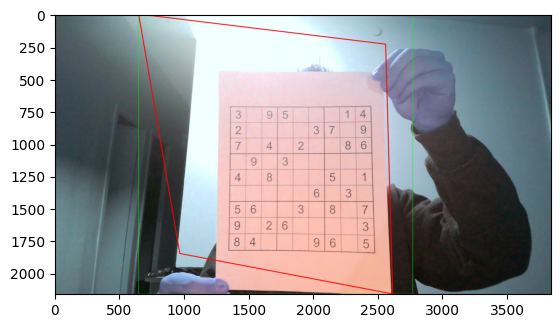

In [33]:
#Method 4: Segment by dominant color

contours = contours[0] if len(contours) == 2 else contours[1]
area_thresh = 0
for c in contours:
    area = cv2.contourArea(c) #find area of the contour
    if area > area_thresh:
        area_thresh = area
        contourMax = c #identify largest contour area -> this should be your paper

paper = np.zeros_like(img)

#draw contour lines on the image using coordinates found in largest contour area
cv2.drawContours(paper,[contourMax], 0, (255,255,255),-1) 

peri = cv2.arcLength(contourMax,True) #parameter for approximation accuracy
#approximate the paper outline with fewer indices, i.e. simplify a more complex shape to rectangle indices
corner = cv2.approxPolyDP(contourMax,0.04*peri, True)
x,y,w,h = cv2.boundingRect(contourMax)
cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

polygon = img.copy()

#overlay the new shape/polygon
cv2.polylines(polygon,[corner],True,(255,0,0),5,cv2.LINE_AA)

plt.imshow(polygon)

In [34]:
from scipy.spatial import distance as dist

#function to order corner points in a clockwise manner for drawing the shape
def order_points(pts):

    xSort = pts[np.argsort(pts[:,0]),:]

    leftMost = xSort[:2,:]
    rightMost = xSort[2:,:]

    leftMost = leftMost[np.argsort(leftMost[:,1]),:]
    (tl,bl) = leftMost

    D = dist.cdist(tl[np.newaxis],rightMost, "euclidean")[0]
    (br,tr) = rightMost[np.argsort(D)[::-1],:]

    return np.array([tl,tr,br,bl],dtype="float32")

In [38]:
#image preprocessing
img = cv2.imread('testImage.png') 

#find image width and height
w,h = img.shape[:2]
B,G,R = cv2.split(img)

#convert image to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

th,thresh1_img = cv2.threshold(B,170,255,cv2.THRESH_BINARY)
th,thresh2_img = cv2.threshold(G,170,255,cv2.THRESH_BINARY)
th,thresh3_img = cv2.threshold(R,170,255,cv2.THRESH_BINARY)

anded = cv2.bitwise_and(thresh1_img, thresh2_img, thresh3_img)

kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(anded,kernel,iterations=8)
dilation = cv2.dilate(erosion,kernel,iterations=15)

#blur image, larger kernel provides closer fit than smaller kernel, but too big a kernel shrinks the paper
blur = cv2.GaussianBlur(dilation,(55,55),0)

#threshold image for white
thresh = cv2.threshold(blur,25,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

#morphological transformation
kernel = np.ones((7,7),np.uint8)
morph = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE, kernel=kernel)
morph = cv2.morphologyEx(morph,cv2.MORPH_OPEN, kernel=kernel)

#find contours, outlines of blurred ROIs 
contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

/var/folders/k7/c0rmybbn2h94nc8bb996p8j00000gn/T/ipykernel_24332/1800846946.py:4: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)
/var/folders/k7/c0rmybbn2h94nc8bb996p8j00000gn/T/ipykernel_24332/1800846946.py:14: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners_ord = np.int0(corners_ord)


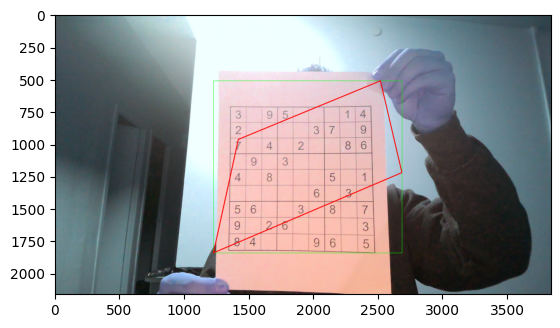

In [39]:
#Method 5: Identify corners using features to track

corners = cv2.goodFeaturesToTrack(thresh,4,0.01,500) #identify corners in image
corners = np.int0(corners)

for i in corners:

    x,y = i.ravel()
    cv2.circle(img,(x,y),3,255,-1) #draw circle at each corner

corners_2d = corners.reshape(-1,2)
corners_ord = order_points(corners_2d) #put corners in clockwise order

corners_ord = np.int0(corners_ord)

paper = np.zeros_like(img)

#draw contour lines on the image using coordinates found in largest contour area
cv2.drawContours(paper,[corners_ord], 0, (255,255,255),-1) 

peri = cv2.arcLength(corners_ord,True) #parameter for approximation accuracy
#approximate the paper outline with fewer indices, i.e. simplify a more complex shape to rectangle indices
corner = cv2.approxPolyDP(corners_ord,0.04*peri, True)

x,y,w,h = cv2.boundingRect(corners_ord)
cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

polygon = img.copy()

#overlay the new shape/polygon
cv2.polylines(polygon,[corner],True,(255,0,0),5,cv2.LINE_AA)

plt.imshow(polygon)

In [40]:
#image preprocessing
img = cv2.imread('TestImage3.png') 

#find image width and height
w,h = img.shape[:2]
B,G,R = cv2.split(img)

#convert image to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

th,thresh1_img = cv2.threshold(B,170,255,cv2.THRESH_BINARY)
th,thresh2_img = cv2.threshold(G,170,255,cv2.THRESH_BINARY)
th,thresh3_img = cv2.threshold(R,170,255,cv2.THRESH_BINARY)

anded = cv2.bitwise_and(thresh1_img, thresh2_img, thresh3_img)

kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(anded,kernel,iterations=8)
dilation = cv2.dilate(erosion,kernel,iterations=15)

#blur image, larger kernel provides closer fit than smaller kernel, but too big a kernel shrinks the paper
blur = cv2.GaussianBlur(dilation,(55,55),0)

#threshold image for white
thresh = cv2.threshold(blur,25,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]